In [1]:
import numpy as np
import itertools
from PIL import Image
import glob
import os
from tqdm import tqdm

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_path = "../input/facades/facades/"

# hyperparameters
n_epochs = 200
input_shape = (3, 256, 256)
b1, b2 = 0.5, 0.999
lr = 2e-4
lambda_id, lambda_cyc = 5.0, 10.0

debug_mode = False
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"): # transforms_=None,
        self.transform = transforms.Compose(transforms_)
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if debug_mode:
            self.files = self.files[:20]


    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")
        
            
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

transforms_ = [
    transforms.Resize((286, 286), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(256, 256))
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_),
    batch_size=4,
    shuffle=True,
    num_workers=0,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}",transforms_=transforms_, mode="val"),
    batch_size=1,
    shuffle=True,
    num_workers=0,
)


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [3]:
class ReplayBuffer:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def push_and_pop(self, images):
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return img
        to_return = []
        for element in images.data:
            element = torch.unsqueeze(element, 0)
            if len(self.images) < self.pool_size: 
                # if the buffer is not full; keep inserting current images to the buffer
                self.images.append(element)
                to_return.append(element)
            else:
                if np.random.uniform() > 0.5:
                    # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    rnd_i = np.random.randint(0, self.pool_size - 1)
                    to_return.append(self.images[rnd_i].clone())
                    self.images[rnd_i] = element
                else:
                    # by another 50% chance, the buffer will return the current image
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [5]:
os.makedirs("images", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [6]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, 9)
G_BA = GeneratorResNet(input_shape, 9)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_AB.to(device)
G_BA.to(device)
D_A.to(device)
D_B.to(device)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

  0%|          | 0/200 [00:00<?, ?it/s]

Gen loss: 2.741156519651413, Discriminator loss: 0.21991263672709466


  1%|          | 2/200 [03:43<6:06:56, 111.19s/it]

Gen loss: 2.4865577137470245, Discriminator loss: 0.13133972235023975


  2%|▏         | 3/200 [05:31<5:59:59, 109.64s/it]

Gen loss: 2.317792947292328, Discriminator loss: 0.11242221623659134


  2%|▏         | 4/200 [07:19<5:55:38, 108.87s/it]

Gen loss: 2.290152431726456, Discriminator loss: 0.10371858790516854


  2%|▎         | 5/200 [09:07<5:52:23, 108.43s/it]

Gen loss: 2.1740050077438355, Discriminator loss: 0.1100769716873765


  3%|▎         | 6/200 [10:54<5:49:48, 108.19s/it]

Gen loss: 2.1150785481929777, Discriminator loss: 0.12392330016940832


  4%|▎         | 7/200 [12:42<5:47:22, 107.99s/it]

Gen loss: 2.0601757538318632, Discriminator loss: 0.1137406026571989


  4%|▍         | 8/200 [14:29<5:45:14, 107.89s/it]

Gen loss: 2.0651592350006105, Discriminator loss: 0.10380208116024732


  4%|▍         | 9/200 [16:17<5:43:19, 107.85s/it]

Gen loss: 2.1641074132919313, Discriminator loss: 0.07786830505356193
Gen loss: 2.006960039138794, Discriminator loss: 0.10557616904377937


  6%|▌         | 11/200 [19:54<5:40:05, 107.96s/it]

Gen loss: 1.9893576729297637, Discriminator loss: 0.1083895180001855


  6%|▌         | 12/200 [21:41<5:37:56, 107.85s/it]

Gen loss: 1.9714270746707916, Discriminator loss: 0.09654960166662932


  6%|▋         | 13/200 [23:29<5:35:59, 107.81s/it]

Gen loss: 1.9931694853305817, Discriminator loss: 0.09611123770475388


  7%|▋         | 14/200 [25:17<5:34:05, 107.77s/it]

Gen loss: 1.929920107126236, Discriminator loss: 0.1237325618416071


  8%|▊         | 15/200 [27:04<5:32:08, 107.72s/it]

Gen loss: 1.943361439704895, Discriminator loss: 0.10949440024793149


  8%|▊         | 16/200 [28:52<5:30:15, 107.70s/it]

Gen loss: 1.9483174574375153, Discriminator loss: 0.11104849066585303


  8%|▊         | 17/200 [30:39<5:28:28, 107.70s/it]

Gen loss: 1.9245129823684692, Discriminator loss: 0.10503638796508312


  9%|▉         | 18/200 [32:27<5:26:40, 107.70s/it]

Gen loss: 1.94622282743454, Discriminator loss: 0.10582494903355837


 10%|▉         | 19/200 [34:15<5:25:01, 107.74s/it]

Gen loss: 1.9697639441490173, Discriminator loss: 0.10234324526041746
Gen loss: 1.9093633210659027, Discriminator loss: 0.10397074561566115


 10%|█         | 21/200 [37:52<5:22:02, 107.94s/it]

Gen loss: 1.8215251111984252, Discriminator loss: 0.11173735216259956


 11%|█         | 22/200 [39:39<5:20:04, 107.89s/it]

Gen loss: 1.9025166237354278, Discriminator loss: 0.10314880348742009


 12%|█▏        | 23/200 [41:27<5:18:09, 107.85s/it]

Gen loss: 1.9203701102733612, Discriminator loss: 0.09782363176345825


 12%|█▏        | 24/200 [43:15<5:16:20, 107.84s/it]

Gen loss: 1.9477250707149505, Discriminator loss: 0.09635709092020989


 12%|█▎        | 25/200 [45:03<5:14:32, 107.84s/it]

Gen loss: 1.863022118806839, Discriminator loss: 0.10155859805643558


 13%|█▎        | 26/200 [46:50<5:12:38, 107.81s/it]

Gen loss: 1.8510720193386079, Discriminator loss: 0.10484147477895021


 14%|█▎        | 27/200 [48:38<5:10:48, 107.79s/it]

Gen loss: 1.867649713754654, Discriminator loss: 0.10989250171929597


 14%|█▍        | 28/200 [50:26<5:09:02, 107.80s/it]

Gen loss: 1.9045421922206878, Discriminator loss: 0.09384843669831752


 14%|█▍        | 29/200 [52:14<5:07:21, 107.85s/it]

Gen loss: 1.846601639986038, Discriminator loss: 0.09492903809994459
Gen loss: 1.8463339293003083, Discriminator loss: 0.0971206072717905


 16%|█▌        | 31/200 [55:51<5:04:27, 108.09s/it]

Gen loss: 1.8715529263019561, Discriminator loss: 0.09238251071423292


 16%|█▌        | 32/200 [57:39<5:02:31, 108.04s/it]

Gen loss: 1.7997578418254851, Discriminator loss: 0.11326906882226467


 16%|█▋        | 33/200 [59:27<5:00:33, 107.98s/it]

Gen loss: 1.8298776042461395, Discriminator loss: 0.10284206483513117


 17%|█▋        | 34/200 [1:01:14<4:58:39, 107.95s/it]

Gen loss: 1.8815050756931304, Discriminator loss: 0.10152768436819315


 18%|█▊        | 35/200 [1:03:02<4:56:40, 107.88s/it]

Gen loss: 1.8582635867595672, Discriminator loss: 0.10653409078717231


 18%|█▊        | 36/200 [1:04:50<4:54:41, 107.81s/it]

Gen loss: 1.811699879169464, Discriminator loss: 0.11531707804650068


 18%|█▊        | 37/200 [1:06:38<4:52:54, 107.82s/it]

Gen loss: 1.8987736773490906, Discriminator loss: 0.09958816338330508


 19%|█▉        | 38/200 [1:08:25<4:51:00, 107.78s/it]

Gen loss: 1.8829227924346923, Discriminator loss: 0.08777646780014038


 20%|█▉        | 39/200 [1:10:13<4:49:07, 107.75s/it]

Gen loss: 1.812964800596237, Discriminator loss: 0.09482895661145449
Gen loss: 1.8237823641300202, Discriminator loss: 0.08757733572274447


 20%|██        | 41/200 [1:13:49<4:46:04, 107.95s/it]

Gen loss: 1.7945748281478882, Discriminator loss: 0.09170422367751599


 21%|██        | 42/200 [1:15:37<4:44:13, 107.93s/it]

Gen loss: 1.8971431136131287, Discriminator loss: 0.08785703901201486


 22%|██▏       | 43/200 [1:17:25<4:42:21, 107.91s/it]

Gen loss: 1.8649966764450072, Discriminator loss: 0.09391035102307796


 22%|██▏       | 44/200 [1:19:13<4:40:28, 107.88s/it]

Gen loss: 1.8128607428073884, Discriminator loss: 0.0974446527659893


 22%|██▎       | 45/200 [1:21:01<4:38:35, 107.84s/it]

Gen loss: 1.8573240792751313, Discriminator loss: 0.10344379212707282


 23%|██▎       | 46/200 [1:22:48<4:36:40, 107.79s/it]

Gen loss: 1.868137505054474, Discriminator loss: 0.08598721772432327


 24%|██▎       | 47/200 [1:24:36<4:34:49, 107.77s/it]

Gen loss: 1.868621416091919, Discriminator loss: 0.0915183887258172


 24%|██▍       | 48/200 [1:26:24<4:33:04, 107.79s/it]

Gen loss: 1.8409718728065492, Discriminator loss: 0.0893328108638525


 24%|██▍       | 49/200 [1:28:12<4:31:14, 107.78s/it]

Gen loss: 1.817620575428009, Discriminator loss: 0.09477781090885401
Gen loss: 1.801975370645523, Discriminator loss: 0.09780124068260193


 26%|██▌       | 51/200 [1:31:48<4:28:08, 107.97s/it]

Gen loss: 1.836430767774582, Discriminator loss: 0.08542226642370224


 26%|██▌       | 52/200 [1:33:36<4:26:07, 107.89s/it]

Gen loss: 1.84688942193985, Discriminator loss: 0.08393827095627784


 26%|██▋       | 53/200 [1:35:24<4:24:13, 107.84s/it]

Gen loss: 1.796492611169815, Discriminator loss: 0.09262273281812668


 27%|██▋       | 54/200 [1:37:11<4:22:20, 107.81s/it]

Gen loss: 1.7754463469982147, Discriminator loss: 0.09426642157137394


 28%|██▊       | 55/200 [1:38:59<4:20:33, 107.81s/it]

Gen loss: 1.7507306611537934, Discriminator loss: 0.09874028842896224


 28%|██▊       | 56/200 [1:40:47<4:18:40, 107.78s/it]

Gen loss: 1.8293637025356293, Discriminator loss: 0.08366490721702576


 28%|██▊       | 57/200 [1:42:35<4:16:49, 107.76s/it]

Gen loss: 1.776739821434021, Discriminator loss: 0.08760888930410146


 29%|██▉       | 58/200 [1:44:22<4:15:00, 107.75s/it]

Gen loss: 1.7869026231765748, Discriminator loss: 0.09251632161438465


 30%|██▉       | 59/200 [1:46:10<4:13:18, 107.79s/it]

Gen loss: 1.7919130265712737, Discriminator loss: 0.09383488666266203
Gen loss: 1.8265870451927184, Discriminator loss: 0.08472592923790216


 30%|███       | 61/200 [1:49:47<4:10:03, 107.94s/it]

Gen loss: 1.8223645389080048, Discriminator loss: 0.07712111931294202


 31%|███       | 62/200 [1:51:34<4:08:04, 107.86s/it]

Gen loss: 1.7406750237941742, Discriminator loss: 0.09083047166466712


 32%|███▏      | 63/200 [1:53:22<4:06:18, 107.87s/it]

Gen loss: 1.8499164175987244, Discriminator loss: 0.08343258392065764


 32%|███▏      | 64/200 [1:55:10<4:04:26, 107.84s/it]

Gen loss: 1.7975880897045136, Discriminator loss: 0.07979911360889673


 32%|███▎      | 65/200 [1:56:58<4:02:41, 107.86s/it]

Gen loss: 1.7608753645420074, Discriminator loss: 0.10722874976694584


 33%|███▎      | 66/200 [1:58:46<4:00:54, 107.87s/it]

Gen loss: 1.7369255805015564, Discriminator loss: 0.08556471548974515


 34%|███▎      | 67/200 [2:00:33<3:59:01, 107.83s/it]

Gen loss: 1.801113030910492, Discriminator loss: 0.08359549805521965


 34%|███▍      | 68/200 [2:02:21<3:57:07, 107.79s/it]

Gen loss: 1.7560014200210572, Discriminator loss: 0.08363060023635625


 34%|███▍      | 69/200 [2:04:09<3:55:15, 107.75s/it]

Gen loss: 1.7469684493541717, Discriminator loss: 0.08370325410738587
Gen loss: 1.779498620033264, Discriminator loss: 0.0777747723646462


 36%|███▌      | 71/200 [2:07:45<3:52:07, 107.97s/it]

Gen loss: 1.7300691938400268, Discriminator loss: 0.10600396478548646


 36%|███▌      | 72/200 [2:09:33<3:50:08, 107.88s/it]

Gen loss: 1.7299192345142365, Discriminator loss: 0.09034131120890379


 36%|███▋      | 73/200 [2:11:21<3:48:18, 107.86s/it]

Gen loss: 1.7638783943653107, Discriminator loss: 0.09645362673327326


 37%|███▋      | 74/200 [2:13:09<3:46:26, 107.83s/it]

Gen loss: 1.6963379096984863, Discriminator loss: 0.08901387136429548


 38%|███▊      | 75/200 [2:14:56<3:44:38, 107.83s/it]

Gen loss: 1.8758294105529785, Discriminator loss: 0.07115676831454039


 38%|███▊      | 76/200 [2:16:44<3:42:48, 107.81s/it]

Gen loss: 1.8119559597969055, Discriminator loss: 0.06728300843387842


 38%|███▊      | 77/200 [2:18:32<3:40:57, 107.78s/it]

Gen loss: 1.7326806151866914, Discriminator loss: 0.08765775598585605


 39%|███▉      | 78/200 [2:20:20<3:39:08, 107.77s/it]

Gen loss: 1.7009677267074585, Discriminator loss: 0.08861555218696594


 40%|███▉      | 79/200 [2:22:07<3:37:15, 107.73s/it]

Gen loss: 1.7333444380760192, Discriminator loss: 0.08973161976784468
Gen loss: 1.6893616354465484, Discriminator loss: 0.08720871780067682


 40%|████      | 81/200 [2:25:44<3:34:02, 107.92s/it]

Gen loss: 1.732975093126297, Discriminator loss: 0.08284791242331266


 41%|████      | 82/200 [2:27:31<3:32:07, 107.86s/it]

Gen loss: 1.705443774461746, Discriminator loss: 0.08611200001090764


 42%|████▏     | 83/200 [2:29:19<3:30:12, 107.80s/it]

Gen loss: 1.728914839029312, Discriminator loss: 0.0793453711271286


 42%|████▏     | 84/200 [2:31:07<3:28:23, 107.79s/it]

Gen loss: 1.7136227118968963, Discriminator loss: 0.07941586405038834


 42%|████▎     | 85/200 [2:32:55<3:26:36, 107.79s/it]

Gen loss: 1.6900655674934386, Discriminator loss: 0.09251938577741385


 43%|████▎     | 86/200 [2:34:42<3:24:46, 107.78s/it]

Gen loss: 1.6322602355480194, Discriminator loss: 0.13065435085445642


 44%|████▎     | 87/200 [2:36:30<3:22:57, 107.77s/it]

Gen loss: 1.7340518760681152, Discriminator loss: 0.08494788631796837


 44%|████▍     | 88/200 [2:38:18<3:21:08, 107.75s/it]

Gen loss: 1.7174983704090119, Discriminator loss: 0.08438930615782737


 44%|████▍     | 89/200 [2:40:06<3:19:18, 107.74s/it]

Gen loss: 1.6524737656116486, Discriminator loss: 0.08851807080209255
Gen loss: 1.6641941738128663, Discriminator loss: 0.08672827608883381


 46%|████▌     | 91/200 [2:43:42<3:16:03, 107.92s/it]

Gen loss: 1.6080711388587952, Discriminator loss: 0.10011208731681108


 46%|████▌     | 92/200 [2:45:30<3:14:07, 107.85s/it]

Gen loss: 1.6434492933750153, Discriminator loss: 0.09318842589855195


 46%|████▋     | 93/200 [2:47:17<3:12:19, 107.85s/it]

Gen loss: 1.6529044270515443, Discriminator loss: 0.09031647443771362


 47%|████▋     | 94/200 [2:49:05<3:10:31, 107.84s/it]

Gen loss: 1.6841984260082246, Discriminator loss: 0.07768713861703873


 48%|████▊     | 95/200 [2:50:53<3:08:43, 107.85s/it]

Gen loss: 1.6640221202373504, Discriminator loss: 0.08246884383261203


 48%|████▊     | 96/200 [2:52:41<3:06:55, 107.84s/it]

Gen loss: 1.7029870545864105, Discriminator loss: 0.08879911448806524


 48%|████▊     | 97/200 [2:54:29<3:05:05, 107.82s/it]

Gen loss: 1.6532531833648683, Discriminator loss: 0.08660192348062992


 49%|████▉     | 98/200 [2:56:16<3:03:13, 107.78s/it]

Gen loss: 1.5352456545829773, Discriminator loss: 0.10899467181414366


 50%|████▉     | 99/200 [2:58:04<3:01:22, 107.75s/it]

Gen loss: 1.6575225985050202, Discriminator loss: 0.09434552606195211
Gen loss: 1.566677038669586, Discriminator loss: 0.10307092484086752


 50%|█████     | 101/200 [3:01:41<2:58:07, 107.95s/it]

Gen loss: 1.6316912364959717, Discriminator loss: 0.09502387527376413


 51%|█████     | 102/200 [3:03:28<2:56:12, 107.89s/it]

Gen loss: 1.6094381320476532, Discriminator loss: 0.0949430937319994


 52%|█████▏    | 103/200 [3:05:16<2:54:18, 107.82s/it]

Gen loss: 1.6516188430786132, Discriminator loss: 0.07781612522900104


 52%|█████▏    | 104/200 [3:07:04<2:52:27, 107.79s/it]

Gen loss: 1.6199751925468444, Discriminator loss: 0.09119986794888973


 52%|█████▎    | 105/200 [3:08:51<2:50:36, 107.75s/it]

Gen loss: 1.580785802602768, Discriminator loss: 0.09919561754912137


 53%|█████▎    | 106/200 [3:10:39<2:48:46, 107.73s/it]

Gen loss: 1.60966663479805, Discriminator loss: 0.09159990724176169


 54%|█████▎    | 107/200 [3:12:27<2:46:56, 107.70s/it]

Gen loss: 1.6594386184215546, Discriminator loss: 0.09112524595111608


 54%|█████▍    | 108/200 [3:14:14<2:45:06, 107.68s/it]

Gen loss: 1.6833726215362548, Discriminator loss: 0.08684841904789209


 55%|█████▍    | 109/200 [3:16:02<2:43:18, 107.67s/it]

Gen loss: 1.720026067495346, Discriminator loss: 0.07477138914167882
Gen loss: 1.6976571846008301, Discriminator loss: 0.07195652697235345


 56%|█████▌    | 111/200 [3:19:38<2:40:05, 107.93s/it]

Gen loss: 1.6442403566837311, Discriminator loss: 0.08794929131865502


 56%|█████▌    | 112/200 [3:21:26<2:38:13, 107.88s/it]

Gen loss: 1.6463328194618225, Discriminator loss: 0.08485190600156783


 56%|█████▋    | 113/200 [3:23:14<2:36:19, 107.81s/it]

Gen loss: 1.6835074019432068, Discriminator loss: 0.08720944475382567


 57%|█████▋    | 114/200 [3:25:02<2:34:31, 107.81s/it]

Gen loss: 1.633508276939392, Discriminator loss: 0.07660193033516408


 57%|█████▊    | 115/200 [3:26:49<2:32:43, 107.81s/it]

Gen loss: 1.629638261795044, Discriminator loss: 0.08847274888306857


 58%|█████▊    | 116/200 [3:28:37<2:30:56, 107.82s/it]

Gen loss: 1.6351263189315797, Discriminator loss: 0.09914186649024487


 58%|█████▊    | 117/200 [3:30:25<2:29:14, 107.88s/it]

Gen loss: 1.6403857970237732, Discriminator loss: 0.08209775468334556


 59%|█████▉    | 118/200 [3:32:13<2:27:27, 107.89s/it]

Gen loss: 1.6412119388580322, Discriminator loss: 0.08753324452787638


 60%|█████▉    | 119/200 [3:34:01<2:25:37, 107.87s/it]

Gen loss: 1.5884394931793213, Discriminator loss: 0.0904620023444295
Gen loss: 1.576368236541748, Discriminator loss: 0.088042978271842


 60%|██████    | 121/200 [3:37:38<2:22:11, 107.99s/it]

Gen loss: 1.5662058997154236, Discriminator loss: 0.08667727332562208


 61%|██████    | 122/200 [3:39:25<2:20:14, 107.87s/it]

Gen loss: 1.58485688328743, Discriminator loss: 0.10206288844347


 62%|██████▏   | 123/200 [3:41:13<2:18:21, 107.81s/it]

Gen loss: 1.507258392572403, Discriminator loss: 0.10818032179027796


 62%|██████▏   | 124/200 [3:43:01<2:16:31, 107.79s/it]

Gen loss: 1.5431549966335296, Discriminator loss: 0.10343408461660147


 62%|██████▎   | 125/200 [3:44:48<2:14:43, 107.77s/it]

Gen loss: 1.5832645320892333, Discriminator loss: 0.0891895266622305


 63%|██████▎   | 126/200 [3:46:36<2:12:52, 107.73s/it]

Gen loss: 1.5330388855934143, Discriminator loss: 0.10340480957180262


 64%|██████▎   | 127/200 [3:48:24<2:11:03, 107.72s/it]

Gen loss: 1.577994179725647, Discriminator loss: 0.0928680344298482


 64%|██████▍   | 128/200 [3:50:11<2:09:16, 107.72s/it]

Gen loss: 1.5426146566867829, Discriminator loss: 0.09950897671282291


 64%|██████▍   | 129/200 [3:51:59<2:07:24, 107.67s/it]

Gen loss: 1.5897331273555755, Discriminator loss: 0.08393742084503174
Gen loss: 1.5558708488941193, Discriminator loss: 0.08214498300105333


 66%|██████▌   | 131/200 [3:55:35<2:04:05, 107.90s/it]

Gen loss: 1.5568631315231323, Discriminator loss: 0.08241472974419593


 66%|██████▌   | 132/200 [3:57:23<2:02:12, 107.83s/it]

Gen loss: 1.5905154645442963, Discriminator loss: 0.08379151742905379


 66%|██████▋   | 133/200 [3:59:10<2:00:19, 107.76s/it]

Gen loss: 1.583747650384903, Discriminator loss: 0.08100635353475809


 67%|██████▋   | 134/200 [4:00:58<1:58:31, 107.75s/it]

Gen loss: 1.571068195104599, Discriminator loss: 0.08131956301629543


 68%|██████▊   | 135/200 [4:02:46<1:56:41, 107.72s/it]

Gen loss: 1.5466811311244966, Discriminator loss: 0.08498570151627063


 68%|██████▊   | 136/200 [4:04:34<1:54:53, 107.71s/it]

Gen loss: 1.6070510697364808, Discriminator loss: 0.08347123064100742


 68%|██████▊   | 137/200 [4:06:21<1:53:03, 107.68s/it]

Gen loss: 1.6325541245937347, Discriminator loss: 0.08061742125079036


 69%|██████▉   | 138/200 [4:08:09<1:51:14, 107.65s/it]

Gen loss: 1.5772519624233245, Discriminator loss: 0.08075690619647503


 70%|██████▉   | 139/200 [4:09:56<1:49:26, 107.65s/it]

Gen loss: 1.611498613357544, Discriminator loss: 0.09849566034972668
Gen loss: 1.6042084074020386, Discriminator loss: 0.0807930313795805


 70%|███████   | 141/200 [4:13:33<1:46:01, 107.83s/it]

Gen loss: 1.5302504122257232, Discriminator loss: 0.09924686074256897


 71%|███████   | 142/200 [4:15:20<1:44:10, 107.77s/it]

Gen loss: 1.594505569934845, Discriminator loss: 0.10035901434719563


 72%|███████▏  | 143/200 [4:17:08<1:42:20, 107.73s/it]

Gen loss: 1.5458816826343535, Discriminator loss: 0.09992118399590254


 72%|███████▏  | 144/200 [4:18:56<1:40:33, 107.74s/it]

Gen loss: 1.5297302913665771, Discriminator loss: 0.1000305077061057


 72%|███████▎  | 145/200 [4:20:43<1:38:43, 107.70s/it]

Gen loss: 1.5524873518943787, Discriminator loss: 0.08840695645660163


 73%|███████▎  | 146/200 [4:22:31<1:36:55, 107.69s/it]

Gen loss: 1.5400988471508026, Discriminator loss: 0.09000301081687212


 74%|███████▎  | 147/200 [4:24:19<1:35:09, 107.72s/it]

Gen loss: 1.5444950187206268, Discriminator loss: 0.08709689859300852


 74%|███████▍  | 148/200 [4:26:06<1:33:22, 107.74s/it]

Gen loss: 1.515854581594467, Discriminator loss: 0.09424156535416842


 74%|███████▍  | 149/200 [4:27:54<1:31:34, 107.74s/it]

Gen loss: 1.542078366279602, Discriminator loss: 0.08409405782818795
Gen loss: 1.578010013103485, Discriminator loss: 0.08121023546904325


 76%|███████▌  | 151/200 [4:31:31<1:28:09, 107.95s/it]

Gen loss: 1.5375263500213623, Discriminator loss: 0.085984046459198


 76%|███████▌  | 152/200 [4:33:18<1:26:18, 107.88s/it]

Gen loss: 1.5493280041217803, Discriminator loss: 0.08628797790035606


 76%|███████▋  | 153/200 [4:35:06<1:24:26, 107.80s/it]

Gen loss: 1.5176323908567428, Discriminator loss: 0.11223801102489234


 77%|███████▋  | 154/200 [4:36:54<1:22:36, 107.75s/it]

Gen loss: 1.5233683621883392, Discriminator loss: 0.08867751277983188


 78%|███████▊  | 155/200 [4:38:41<1:20:47, 107.73s/it]

Gen loss: 1.5422306245565414, Discriminator loss: 0.08930925553664565


 78%|███████▊  | 156/200 [4:40:29<1:18:58, 107.70s/it]

Gen loss: 1.5303800749778746, Discriminator loss: 0.08107447888702154


 78%|███████▊  | 157/200 [4:42:17<1:17:09, 107.67s/it]

Gen loss: 1.5279445141553878, Discriminator loss: 0.09279891334474087


 79%|███████▉  | 158/200 [4:44:04<1:15:21, 107.66s/it]

Gen loss: 1.5067890626192093, Discriminator loss: 0.0945161672309041


 80%|███████▉  | 159/200 [4:45:52<1:13:34, 107.66s/it]

Gen loss: 1.5044015270471573, Discriminator loss: 0.10471555776894093
Gen loss: 1.4740536284446717, Discriminator loss: 0.10183457367122173


 80%|████████  | 161/200 [4:49:28<1:10:06, 107.87s/it]

Gen loss: 1.5332798266410828, Discriminator loss: 0.09452341694384814


 81%|████████  | 162/200 [4:51:16<1:08:19, 107.89s/it]

Gen loss: 1.5098970782756806, Discriminator loss: 0.0912512556090951


 82%|████████▏ | 163/200 [4:53:04<1:06:29, 107.84s/it]

Gen loss: 1.542933457493782, Discriminator loss: 0.09383004996925592


 82%|████████▏ | 164/200 [4:54:51<1:04:39, 107.77s/it]

Gen loss: 1.5423097479343415, Discriminator loss: 0.08512908197939396


 82%|████████▎ | 165/200 [4:56:39<1:02:51, 107.76s/it]

Gen loss: 1.5088962399959565, Discriminator loss: 0.10543764520436526


 83%|████████▎ | 166/200 [4:58:27<1:01:02, 107.71s/it]

Gen loss: 1.5727039849758149, Discriminator loss: 0.08690453249961137


 84%|████████▎ | 167/200 [5:00:14<59:14, 107.71s/it]  

Gen loss: 1.529741415977478, Discriminator loss: 0.08747859109193086


 84%|████████▍ | 168/200 [5:02:02<57:26, 107.71s/it]

Gen loss: 1.5210108256340027, Discriminator loss: 0.08721675973385573


 84%|████████▍ | 169/200 [5:03:50<55:37, 107.67s/it]

Gen loss: 1.468622921705246, Discriminator loss: 0.10051293708384038
Gen loss: 1.4963045406341553, Discriminator loss: 0.09026136033236981


 86%|████████▌ | 171/200 [5:07:26<52:06, 107.83s/it]

Gen loss: 1.5178141379356385, Discriminator loss: 0.09692872442305088


 86%|████████▌ | 172/200 [5:09:13<50:17, 107.75s/it]

Gen loss: 1.4924930608272553, Discriminator loss: 0.09973439641296863


 86%|████████▋ | 173/200 [5:11:01<48:27, 107.68s/it]

Gen loss: 1.5202815020084381, Discriminator loss: 0.08798168171197177


 87%|████████▋ | 174/200 [5:12:49<46:39, 107.69s/it]

Gen loss: 1.5349062383174896, Discriminator loss: 0.08592796560376882


 88%|████████▊ | 175/200 [5:14:36<44:51, 107.65s/it]

Gen loss: 1.49418248295784, Discriminator loss: 0.0992446556314826


 88%|████████▊ | 176/200 [5:16:24<43:03, 107.63s/it]

Gen loss: 1.5071855640411378, Discriminator loss: 0.09202559314668178


 88%|████████▊ | 177/200 [5:18:11<41:14, 107.60s/it]

Gen loss: 1.511651713848114, Discriminator loss: 0.09494983222335578


 89%|████████▉ | 178/200 [5:19:59<39:28, 107.64s/it]

Gen loss: 1.4748607993125915, Discriminator loss: 0.09321515314280987


 90%|████████▉ | 179/200 [5:21:47<37:40, 107.63s/it]

Gen loss: 1.5125260508060456, Discriminator loss: 0.08378398522734642
Gen loss: 1.5387802422046661, Discriminator loss: 0.0762801394611597


 90%|█████████ | 181/200 [5:25:23<34:10, 107.91s/it]

Gen loss: 1.5743732583522796, Discriminator loss: 0.08360132586210967


 91%|█████████ | 182/200 [5:27:11<32:20, 107.83s/it]

Gen loss: 1.5848554944992066, Discriminator loss: 0.07380175599828362


 92%|█████████▏| 183/200 [5:28:59<30:32, 107.77s/it]

Gen loss: 1.556089025735855, Discriminator loss: 0.07716397363692522


 92%|█████████▏| 184/200 [5:30:46<28:44, 107.76s/it]

Gen loss: 1.4055653297901154, Discriminator loss: 0.12625889532268048


 92%|█████████▎| 185/200 [5:32:34<26:55, 107.73s/it]

Gen loss: 1.4821527600288391, Discriminator loss: 0.0961056649684906


 93%|█████████▎| 186/200 [5:34:22<25:07, 107.69s/it]

Gen loss: 1.4148516738414765, Discriminator loss: 0.11191961415112019


 94%|█████████▎| 187/200 [5:36:09<23:19, 107.66s/it]

Gen loss: 1.5159387242794038, Discriminator loss: 0.09296795312315226


 94%|█████████▍| 188/200 [5:37:57<21:31, 107.65s/it]

Gen loss: 1.5094224870204926, Discriminator loss: 0.09551141053438186


 94%|█████████▍| 189/200 [5:39:44<19:44, 107.65s/it]

Gen loss: 1.4399913918972016, Discriminator loss: 0.1057989389449358
Gen loss: 1.4247451508045197, Discriminator loss: 0.1058013865351677


 96%|█████████▌| 191/200 [5:43:21<16:10, 107.86s/it]

Gen loss: 1.5072761642932893, Discriminator loss: 0.09298302292823792


 96%|█████████▌| 192/200 [5:45:08<14:22, 107.77s/it]

Gen loss: 1.4850734543800355, Discriminator loss: 0.08866415288299322


 96%|█████████▋| 193/200 [5:46:56<12:33, 107.69s/it]

Gen loss: 1.457105724811554, Discriminator loss: 0.09477485470473766


 97%|█████████▋| 194/200 [5:48:43<10:45, 107.64s/it]

Gen loss: 1.385530651807785, Discriminator loss: 0.11684555500745773


 98%|█████████▊| 195/200 [5:50:31<08:58, 107.63s/it]

Gen loss: 1.440641574859619, Discriminator loss: 0.10428308073431253


 98%|█████████▊| 196/200 [5:52:19<07:10, 107.63s/it]

Gen loss: 1.5088056099414826, Discriminator loss: 0.10445238441228867


 98%|█████████▊| 197/200 [5:54:06<05:22, 107.60s/it]

Gen loss: 1.478493970632553, Discriminator loss: 0.09429858043789864


 99%|█████████▉| 198/200 [5:55:54<03:35, 107.60s/it]

Gen loss: 1.478356282711029, Discriminator loss: 0.10553058672696353


100%|█████████▉| 199/200 [5:57:41<01:47, 107.60s/it]

Gen loss: 1.4818651628494264, Discriminator loss: 0.09241746861487626
Gen loss: 1.4865078663825988, Discriminator loss: 0.08476332891732455


100%|██████████| 200/200 [5:59:30<00:00, 107.85s/it]


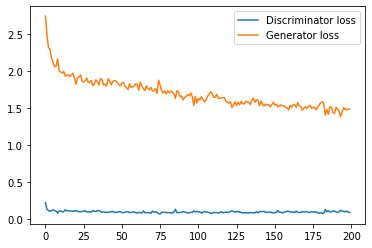

In [7]:
train_losses_gen, train_losses_disc = [], []
for epoch in tqdm(range(1, n_epochs+1)):
    
    #### Training
    loss_gen, loss_disc = [], []
    for batch_idx, batch in enumerate(train_dataloader):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator-A
        D_A.train()
        optimizer_D_A.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        ### Train Discriminator-B
        D_B.train()
        optimizer_D_B.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B) / 2

        ### Log Progress
        loss_gen.append(loss_G.item())
        loss_disc.append(loss_D.item())
    
    gen_temp = np.mean(loss_gen)
    disc_temp = np.mean(loss_disc)
    print(f'Gen loss: {gen_temp}, Discriminator loss: {disc_temp}')
    train_losses_gen.append(gen_temp)
    train_losses_disc.append(disc_temp)
    
    # save checkpoints and generate samples on test set once in a while
    if epoch % 10 == 0 or epoch == 1:
        torch.save(G_AB.state_dict(), "./models/G_AB.pth")
        torch.save(G_BA.state_dict(), "./models/G_BA.pth")
        torch.save(D_A.state_dict(), "./models/D_A.pth")
        torch.save(D_B.state_dict(), "./models/D_B.pth")
        for batch_idx, batch in enumerate(val_dataloader):
            # generate
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))
            G_BA.eval()
            fake_A = G_BA(real_B)
            
            # save images 
            real_A = make_grid(real_A, nrow=1, normalize=True)
            real_B = make_grid(real_B, nrow=1, normalize=True)
            fake_A = make_grid(fake_A, nrow=1, normalize=True)
            image_grid = torch.cat((real_B, fake_A, real_A), -1)
            save_image(image_grid, f"./images/cycleGAN_sample_{epoch}_{batch_idx}.png", normalize=False)
            
            # 3 samples per 10 epochs is enough
            if batch_idx > 3:
                break

                
plt.plot(train_losses_disc)
plt.plot(train_losses_gen)
plt.legend(['Discriminator loss', 'Generator loss']);
